# Modelagem
# Objetivo: Construir e avaliar modelos preditivos para estimar a nota do ENEM com base nas características dos candidatos.

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from category_encoders import TargetEncoder
# Importação dos algoritmos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
# Carregando os dados preparados
X_train = joblib.load('data/X_train.pkl')
X_val = joblib.load('data/X_val.pkl')
X_test = joblib.load('data/X_test.pkl')
y_train = joblib.load('data/y_train.pkl')
y_val = joblib.load('data/y_val.pkl')
y_test = joblib.load('data/y_test.pkl')

# Removendo features demográficas sensíveis (sexo e raça).
features_sensíveis = ['TP_SEXO', 'TP_COR_RACA']
X_train = X_train.drop(columns=features_sensíveis, errors='ignore')
X_val = X_val.drop(columns=features_sensíveis, errors='ignore')
X_test = X_test.drop(columns=features_sensíveis, errors='ignore')

print(f"Features removidas: {features_sensíveis}")
print(f"Shape dos dados após remoção: {X_train.shape}")

X_train.columns

Features removidas: ['TP_SEXO', 'TP_COR_RACA']
Shape dos dados após remoção: (2142611, 32)


Index(['TP_FAIXA_ETARIA', 'TP_ESTADO_CIVIL', 'TP_ST_CONCLUSAO', 'TP_ESCOLA',
       'IN_TREINEIRO', 'SG_UF_PROVA', 'TP_LINGUA', 'Q001', 'Q002', 'Q003',
       'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012',
       'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021',
       'Q022', 'Q023', 'Q024', 'Q025'],
      dtype='object')

In [ ]:
# Funções de avaliação
def avaliar_modelo(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {
        "MAE": mae,
        "MAPE (%)": mape,
        "MSE": mse,
        "RMSE": rmse
    }

def avaliar_modelo_cv(pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error'):
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
    return scores

In [ ]:
print(X_train.shape)
X_train.columns

(2142611, 32)


Index(['TP_FAIXA_ETARIA', 'TP_ESTADO_CIVIL', 'TP_ST_CONCLUSAO', 'TP_ESCOLA',
       'IN_TREINEIRO', 'SG_UF_PROVA', 'TP_LINGUA', 'Q001', 'Q002', 'Q003',
       'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012',
       'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021',
       'Q022', 'Q023', 'Q024', 'Q025'],
      dtype='object')

In [ ]:
#Cardinalidade
X_train.nunique().sort_values(ascending=False)

SG_UF_PROVA        27
TP_FAIXA_ETARIA    20
Q005               20
Q006               17
Q001                8
Q002                8
Q003                6
Q004                6
Q017                5
Q019                5
Q012                5
Q022                5
Q024                5
Q016                5
Q015                5
Q014                5
Q013                5
Q010                5
Q011                5
TP_ESTADO_CIVIL     5
Q009                5
Q008                5
Q007                4
TP_ST_CONCLUSAO     4
TP_ESCOLA           3
TP_LINGUA           2
Q018                2
IN_TREINEIRO        2
Q020                2
Q021                2
Q023                2
Q025                2
dtype: int64

In [ ]:
resultados_modelos = {}

 A classe TratadorNaoSei trata um problema específico do questionário
 socioeconômico do ENEM: candidatos que não sabem informações sobre a
 escolaridade dos pais.

 O Problema:

 Nas questões Q001-Q004 , alguns candidatos respondem "Não sei" (códigos 'H' e 'F'). Simplesmente ignorar essas respostas desperdiçaria informação valiosa.

 A Solução: Cria novas variáveis (Q001_naosei, Q002_naosei, etc.) que marcam quando o candidato não soube responder.
 Converter "Não sei" para nulo, permitindo imputação posterior.
   Em vez de perder a informação "não sei", o modelo agora pode aprender que o próprio desconhecimento é um preditor relevante da nota final.

In [ ]:
class TratadorNaoSei(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_['Q001_naosei'] = np.where(X_['Q001'] == 'H', 1, 0)
        X_['Q002_naosei'] = np.where(X_['Q002'] == 'H', 1, 0)
        X_['Q003_naosei'] = np.where(X_['Q003'] == 'F', 1, 0)
        X_['Q004_naosei'] = np.where(X_['Q004'] == 'F', 1, 0)
        X_.loc[X_['Q001'] == 'H', 'Q001'] = np.nan
        X_.loc[X_['Q002'] == 'H', 'Q002'] = np.nan
        X_.loc[X_['Q003'] == 'F', 'Q003'] = np.nan
        X_.loc[X_['Q004'] == 'F', 'Q004'] = np.nan
        return X_
    
class AgrupadorCategorias(BaseEstimator, TransformerMixin):
    """
    Aplica mapeamentos categóricos para reduzir cardinalidade
    """
    def __init__(self):
        # Idade: 1=Adolescente, 2=Jovem, 3=Adulto jovem, 4=Meia-idade, 5=Idoso
        self.mapa_grupos_idade = {
            1: 1, 2: 1,                                    # Adolescente
            3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2,     # Jovem adulto
            10: 3, 11: 3, 12: 3, 13: 3,                    # Adulto jovem
            14: 4, 15: 4, 16: 4, 17: 4,                    # Meia-idade
            18: 5, 19: 5, 20: 5                            # Idoso
        }
        
        # Renda: 0=Sem renda, 1=Classe E, 2=Classe D, 3=Classe C, 4=Classe B, 5=Classe A
        self.renda_abep = {
            "A": 0, "B": 1, "C": 2, "D": 2, "E": 3, "F": 3, 
            "G": 3, "H": 3, "I": 4, "J": 4, "K": 4, "L": 4, 
            "M": 4, "N": 5, "O": 5, "P": 5, "Q": 5
        }

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        
        if 'TP_FAIXA_ETARIA' in X_.columns:
            X_['TP_FAIXA_ETARIA'] = X_['TP_FAIXA_ETARIA'].map(self.mapa_grupos_idade)
        
        if 'Q006' in X_.columns:
            X_['Q006'] = X_['Q006'].map(self.renda_abep)
            

        return X_

def criar_pipeline(modelo):
    col_numericas = ['Q005']

    categorica_nominal = [
        'TP_ESTADO_CIVIL',
        'TP_ESCOLA', 
        'SG_UF_PROVA',  
    ]

    categorica_ordinal = [
        'TP_ST_CONCLUSAO', 'TP_FAIXA_ETARIA', 'Q006',  # Idade e renda como ordinal numérica
        'Q001', 'Q002', 'Q003', 'Q004', 'Q007', 'Q008', 'Q009',
        'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016',
        'Q017', 'Q019', 'Q022', 'Q024', 'Q018', 'Q020', 'Q021', 'Q023',
        'Q025', 'IN_TREINEIRO', 'TP_LINGUA'
    ]
    
    transformador_numerico = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])

    transformador_onehot = Pipeline(steps=[
        ("onehot", OneHotEncoder(handle_unknown='ignore'))
    ])

    transformador_categorico_ordinal = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy='constant', fill_value='Desconhecido')),
        ("ordinal", OrdinalEncoder())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", transformador_numerico, col_numericas),
            ("cat_onehot", transformador_onehot, categorica_nominal),
            ("cat_ordinal", transformador_categorico_ordinal, categorica_ordinal)
        ],
        remainder='passthrough'
    )

    pipeline_final = Pipeline(steps=[
        ("tratador_nao_sei", TratadorNaoSei()),
        ('agrupamento', AgrupadorCategorias()),
        ("preprocess", preprocessor),
        ("modelo", modelo)
    ])

    return pipeline_final

In [ ]:
# --- Listas de Modelos ---
modelos_com_escala = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
}

In [ ]:
for nome_modelo, modelo in modelos_com_escala.items():
    pipeline = criar_pipeline(modelo)
    scores = avaliar_modelo_cv(pipeline, X_train, y_train)
    print(f"{nome_modelo}: RMSE médio = {-scores.mean():.4f}")
    pipeline.fit(X_train, y_train)
    y_pred_val = pipeline.predict(X_val)
    metricas_val = avaliar_modelo(y_val, y_pred_val)
    resultados_modelos[nome_modelo] = [-scores.mean(), metricas_val['RMSE']]

Ridge: RMSE médio = 78.0516
Lasso: RMSE médio = 78.1293
ElasticNet: RMSE médio = 78.4678


 Os modelos lineares apresentam limitações ao lidar com dados complexos e não-lineares,
 especialmente quando há interações entre variáveis que não são capturadas por transformações simples.
 Para superar essas limitações, testamos agora modelos baseados em árvores que:
 1. Capturam automaticamente interações não-lineares entre features
 2. Não necessitam de escalonamento dos dados
 3. Podem lidar melhor com diferentes tipos de variáveis categóricas
 Por isso, criamos uma nova pipeline otimizada para esses algoritmos.

# Abordagem com modelos baseados em árvores, que não necessitam de escalonamento, entre outras diferenças.

In [ ]:
def criar_pipeline_arvore_normal(modelo):
    col_numericas = ['Q005']
    categorica_nominal_pequena = ['TP_ESTADO_CIVIL','TP_ESCOLA','SG_UF_PROVA']
    categorica_ordinal = [
        'TP_ST_CONCLUSAO','TP_FAIXA_ETARIA','Q001','Q002','Q003','Q004',
        'Q006','Q007','Q008','Q009','Q010','Q011','Q012','Q013','Q014',
        'Q015','Q016','Q017','Q019','Q022','Q024','IN_TREINEIRO',
        'TP_LINGUA','Q018','Q020','Q021','Q023','Q025'
    ]
    transformador_ordinal = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy='constant', fill_value='Desconhecido')),
        ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
    transformador_onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    #transformador_target = TargetEncoder(cols=categorica_nominal_alta)
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat_onehot", transformador_onehot, categorica_nominal_pequena),
            ("cat_ord", transformador_ordinal, categorica_ordinal)
        ],
        remainder='passthrough'
    )
    pipeline_final = Pipeline([
        ("tratador_nao_sei", TratadorNaoSei()),
        ("preprocess", preprocessor),
        ("modelo", modelo)
    ])
    return pipeline_final

In [ ]:
modelos_arvore_normal = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingRegressor(random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, n_jobs=-1, random_state=42)
}

In [ ]:
for nome_modelo, modelo in modelos_arvore_normal.items():
    pipeline = criar_pipeline_arvore_normal(modelo)
    scores = avaliar_modelo_cv(pipeline, X_train, y_train)
    print(f"{nome_modelo}: RMSE médio = {-scores.mean():.4f}, std = {scores.std():.4f}")
    pipeline.fit(X_train, y_train)
    y_pred_val = pipeline.predict(X_val)
    metricas_val = avaliar_modelo(y_val, y_pred_val)
    resultados_modelos[nome_modelo] = [-scores.mean(), metricas_val['RMSE']]

Decision Tree: RMSE médio = 110.4010, std = 0.0923
Hist Gradient Boosting: RMSE médio = 76.2110, std = 0.0495
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 1714088, number of used features: 68
[LightGBM] [Info] Start training from score 540.637840


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 1714089, number of used features: 68
[LightGBM] [Info] Start training from score 540.648418


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 1714089, number of used features: 68
[LightGBM] [Info] Start training from score 540.640407


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 1714089, number of used features: 68
[LightGBM] [Info] Start training from score 540.605469


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 1714089, number of used features: 68
[LightGBM] [Info] Start training from score 540.702090


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM: RMSE médio = 76.2062, std = 0.0503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 2142611, number of used features: 68
[LightGBM] [Info] Start training from score 540.646845


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


XGBoost: RMSE médio = 76.2891, std = 0.0403


In [ ]:
def criar_pipeline_catboost():
    col_numericas = ['Q005']

    # Apenas categóricas de baixa cardinalidade como nativas
    col_categoricas_nativas = ['TP_ESTADO_CIVIL', 'TP_ESCOLA']

    # Resto como ordinal (mais seguro)
    col_categoricas_ordinal = [
        'SG_UF_PROVA', 'TP_ST_CONCLUSAO', 'TP_FAIXA_ETARIA', 'Q006',
        'Q001', 'Q002', 'Q003', 'Q004', 'Q007', 'Q008', 'Q009',
        'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016',
        'Q017', 'Q019', 'Q022', 'Q024', 'Q018', 'Q020', 'Q021',
        'Q023', 'Q025', 'IN_TREINEIRO', 'TP_LINGUA'
    ]

    # Transformadores
    transformador_cat_nativas = SimpleImputer(strategy='most_frequent', fill_value='Desconhecido')
    transformador_ordinal = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy='most_frequent', fill_value='Desconhecido')),
        ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
    transformador_num = SimpleImputer(strategy='median')

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat_nativas", transformador_cat_nativas, col_categoricas_nativas),
            ("cat_ord", transformador_ordinal, col_categoricas_ordinal),
            ("num", transformador_num, col_numericas)
        ],
        remainder='passthrough'
    )

    # CatBoost sem categorical features especificadas (dados já preprocessados)
    modelo = CatBoostRegressor(
        iterations=200,
        learning_rate=0.1,
        random_state=42,
        verbose=False
    )

    pipeline_final = Pipeline([
        ("tratador_nao_sei", TratadorNaoSei()),
        ("agrupamento", AgrupadorCategorias()),
        ("preprocessor", preprocessor),
        ("modelo", modelo)
    ])

    return pipeline_final

# Código para testar
pipeline_catboost = criar_pipeline_catboost()
scores_catboost = avaliar_modelo_cv(pipeline_catboost, X_train, y_train)
print(f"CatBoost: RMSE médio = {-scores_catboost.mean():.4f}, std = {scores_catboost.std():.4f}")
pipeline_catboost.fit(X_train, y_train)
y_pred_val = pipeline_catboost.predict(X_val)
metricas_val = avaliar_modelo(y_val, y_pred_val)
resultados_modelos['CatBoost'] = [-scores_catboost.mean(), metricas_val['RMSE']]

CatBoost: RMSE médio = 76.5788, std = 0.0452


 ## Resultados dos Modelos de Árvore

 **Melhores Resultados:**
 - **LightGBM**: 76.2062 RMSE (melhor modelo)
 - **Hist Gradient Boosting**: 76.2110 RMSE
 - **XGBoost**: 76.2891 RMSE
 - **Decision Tree**: 110.4010 RMSE (muito inferior)
 - **CatBoost**: 76.5788 RMSE

 Os algoritmos de ensemble (LightGBM, XGBoost, HistGB) tiveram performance similar e excelente,
 enquanto Decision Tree simples teve performance muito inferior, confirmando a necessidade
 de modelos mais sofisticados. LightGBM foi escolhido para otimização de hiperparâmetros.

In [ ]:
resultados_modelos

{'Ridge': [78.05161892593328, 78.01808451938935],
 'Lasso': [78.12928228371707, 78.09789295638235],
 'ElasticNet': [78.46777450694022, 78.43653057253096],
 'Decision Tree': [110.4009752167793, 110.2887499295928],
 'Hist Gradient Boosting': [76.21104346771038, 76.19635874053175],
 'LightGBM': [76.20621059497395, 76.20026566395694],
 'XGBoost': [76.28908228688809, 76.27627244849836],
 'CatBoost': [76.57881880356831, 76.53731415378489]}

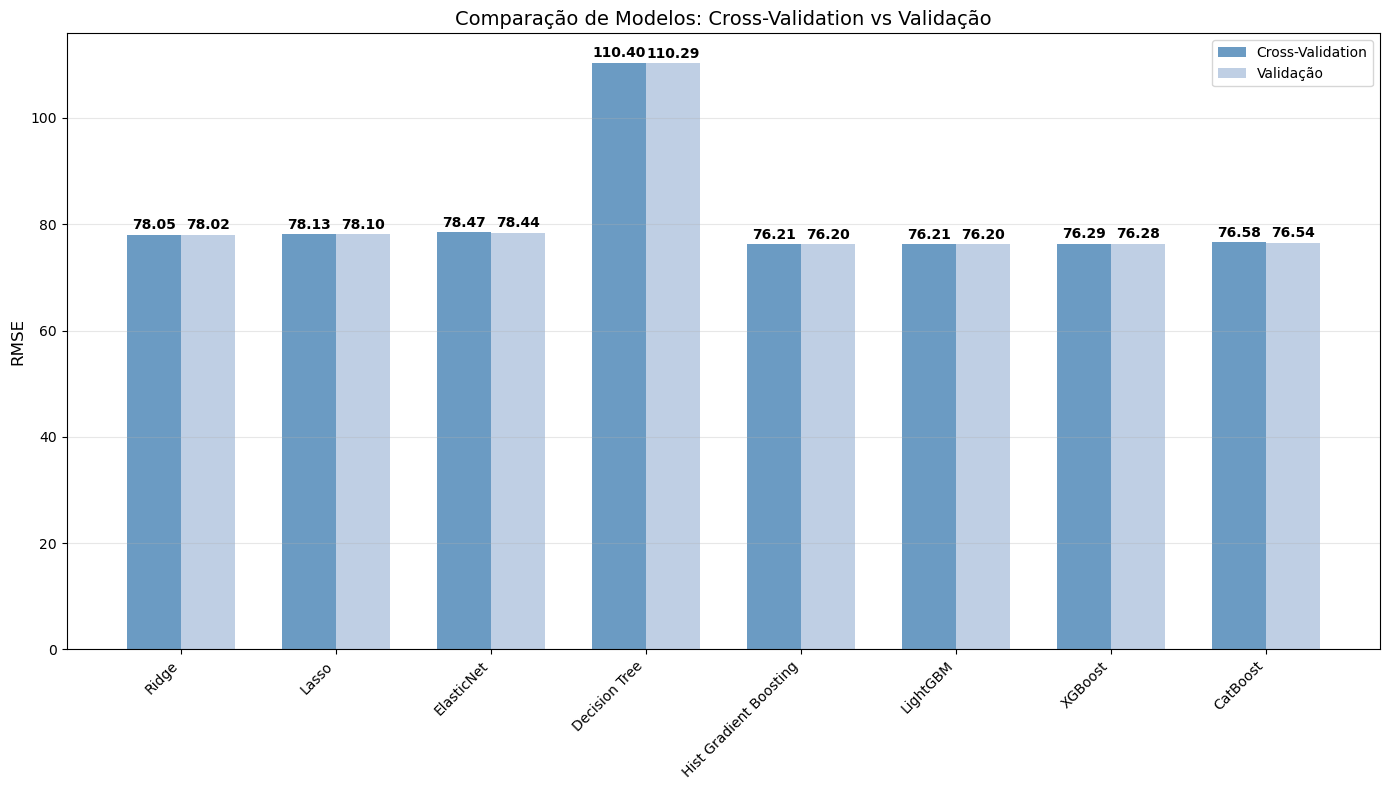


ANÁLISE: Diferenças entre CV e Validação
Ridge                    : CV=78.05 | Val=78.02 | Diff=0.03
Lasso                    : CV=78.13 | Val=78.10 | Diff=0.03
ElasticNet               : CV=78.47 | Val=78.44 | Diff=0.03
Decision Tree            : CV=110.40 | Val=110.29 | Diff=0.11
Hist Gradient Boosting   : CV=76.21 | Val=76.20 | Diff=0.01
LightGBM                 : CV=76.21 | Val=76.20 | Diff=0.01
XGBoost                  : CV=76.29 | Val=76.28 | Diff=0.01
CatBoost                 : CV=76.58 | Val=76.54 | Diff=0.04

ANÁLISE: Consistência entre Cross-Validation e Validação
A pequena diferença entre CV e validação indica:
• Boa generalização: Modelos não apresentam overfitting significativo
• Pipeline robusto: Preprocessing e validação cruzada estão bem calibrados
• Distribuição homogênea: Conjuntos train/val têm características similares
• Estabilidade do modelo: Performance consistente em diferentes subconjuntos

Essa convergência é um indicador positivo de qualidade do modelo e
sug

In [ ]:
# Plotagem dos modelos
# Extrair dados
modelos = list(resultados_modelos.keys())
cv_scores = [resultados_modelos[m][0] for m in modelos]
val_scores = [resultados_modelos[m][1] for m in modelos]

# Gráfico melhorado
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(modelos))
width = 0.35

# Barras com cores azuis diferentes
bars1 = ax.bar(x - width/2, cv_scores, width, label='Cross-Validation', 
               color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, val_scores, width, label='Validação', 
               color='lightsteelblue', alpha=0.8)

# Configurações do gráfico
ax.set_xticks(x)
ax.set_xticklabels(modelos, rotation=45, ha='right')
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Comparação de Modelos: Cross-Validation vs Validação', fontsize=14)
ax.legend()

# Adicionar valores em cima das barras
for bar, score in zip(bars1, cv_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{score:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar, score in zip(bars2, val_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{score:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Melhorar layout
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Analisar diferenças entre CV e Validação
print("\nANÁLISE: Diferenças entre CV e Validação")
print("="*50)
for modelo in modelos:
    cv = resultados_modelos[modelo][0]
    val = resultados_modelos[modelo][1]
    diff = abs(cv - val)
    print(f"{modelo:<25}: CV={cv:.2f} | Val={val:.2f} | Diff={diff:.2f}")
    
print(f"\nANÁLISE: Consistência entre Cross-Validation e Validação")
print("="*55)
print("A pequena diferença entre CV e validação indica:")
print("• Boa generalização: Modelos não apresentam overfitting significativo")
print("• Pipeline robusto: Preprocessing e validação cruzada estão bem calibrados")
print("• Distribuição homogênea: Conjuntos train/val têm características similares")
print("• Estabilidade do modelo: Performance consistente em diferentes subconjuntos")
print("\nEssa convergência é um indicador positivo de qualidade do modelo e")
print("sugere que a performance observada será mantida em dados de produção.")

# Tunagem de Hiperparâmetros com Optuna
 A tunagem de hiperparâmetros é um processo crucial para otimizar o desempenho de modelos de machine learning.
 Em vez de usar métodos tradicionais como Grid Search ou Random Search, utilizamos otimização bayesiana
 através da biblioteca Optuna, que oferece várias vantagens:
 ### Por que Otimização Bayesiana?

 1. **Eficiência**: Grid Search testa todas as combinações (exponencialmente custoso),
    Random Search é melhor mas ainda ineficiente. A otimização bayesiana aprende
    dos trials anteriores para focar em regiões promissoras do espaço de hiperparâmetros.

 2. **Tree-structured Parzen Estimator (TPE)**: O Optuna usa TPE por padrão, que modela
    a distribuição de hiperparâmetros condicionada ao desempenho. Trials com melhor
    performance informam onde buscar próximos candidatos.

 3. **Convergência mais rápida**: Enquanto Random Search pode precisar de centenas
    de trials, otimização bayesiana frequentemente encontra bons resultados em 20-50 trials.

 ### Estratégia de Otimização:
 - **Hold-out validation**: Mais rápido que cross-validation para otimização
 - **Foco nos parâmetros mais importantes**: learning_rate, num_leaves, n_estimators
 - **Ranges inteligentes**: Baseados na literatura e experiência prática
 - **TPESampler**: Algoritmo bayesiano que balancia exploração vs exploração

In [ ]:
import optuna as opt
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def objective_rapido(trial):
    # Apenas 3 parâmetros mais críticos (mais focado)
    learning_rate = trial.suggest_float('learning_rate', 0.08, 0.12)  # Range menor e mais focado
    num_leaves = trial.suggest_int('num_leaves', 150, 300)  # Range menor
    n_estimators = trial.suggest_int('n_estimators', 600, 1000)  # Range menor

    # Hold-out validation (muito mais rápido que CV)
    from sklearn.model_selection import train_test_split
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    pipeline = criar_pipeline_arvore_normal(
        LGBMRegressor(
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            n_estimators=n_estimators,
            boosting_type='gbdt',  # Só GBDT (DART é mais lento)
            random_state=42,
            verbose=-1,
            n_jobs=-1
        )
    )

    pipeline.fit(X_tr, y_tr)
    y_pred = pipeline.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    print(f'Trial {trial.number}: RMSE = {rmse:.4f}')
    return rmse

# Otimização mais rápida e inteligente
print("Tunagem rápida de hiperparâmetros...")
study = opt.create_study(direction='minimize', sampler=opt.samplers.TPESampler())  # Sampler mais inteligente
study.optimize(objective_rapido, n_trials=20)  # Apenas 20 trials (bem mais rápido)

print(f"\nMelhor RMSE: {study.best_value:.4f}")
print("Melhores parâmetros:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

# Modelo final otimizado - treinar com train+val e testar no conjunto de teste
melhor_modelo = LGBMRegressor(**study.best_params, random_state=42, verbose=-1)

# Treinar com train + validation combinados para usar todos os dados disponíveis
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

pipeline_final = criar_pipeline_arvore_normal(melhor_modelo)
pipeline_final.fit(X_train_full, y_train_full)

# TESTE FINAL - dados nunca vistos antes
y_pred_test = pipeline_final.predict(X_test)
metricas_test = avaliar_modelo(y_test, y_pred_test)

print(f"\n RESULTADO FINAL NO TESTE:")
for metrica, valor in metricas_test.items():
    print(f"  {metrica}: {valor:.4f}")

rmse_test_final = metricas_test['RMSE']
print(f"\nMelhoria vs baseline: {76.2062} → {rmse_test_final:.4f}")

[I 2025-09-24 13:40:14,818] A new study created in memory with name: no-name-ab87fd55-94db-45ff-a832-b13ffa65338d


Tunagem rápida de hiperparâmetros...


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:40:48,663] Trial 0 finished with value: 75.63258675352932 and parameters: {'learning_rate': 0.0861991564014281, 'num_leaves': 287, 'n_estimators': 669}. Best is trial 0 with value: 75.63258675352932.


Trial 0: RMSE = 75.6326


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:41:22,599] Trial 1 finished with value: 75.68060806831875 and parameters: {'learning_rate': 0.10366698476441256, 'num_leaves': 300, 'n_estimators': 683}. Best is trial 0 with value: 75.63258675352932.


Trial 1: RMSE = 75.6806


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:41:53,335] Trial 2 finished with value: 75.60853986720457 and parameters: {'learning_rate': 0.09032024480965462, 'num_leaves': 235, 'n_estimators': 611}. Best is trial 2 with value: 75.60853986720457.


Trial 2: RMSE = 75.6085


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:42:30,416] Trial 3 finished with value: 75.66117857315807 and parameters: {'learning_rate': 0.0980902373755794, 'num_leaves': 208, 'n_estimators': 949}. Best is trial 2 with value: 75.60853986720457.


Trial 3: RMSE = 75.6612


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:43:05,468] Trial 4 finished with value: 75.61337084554702 and parameters: {'learning_rate': 0.09549473065407497, 'num_leaves': 173, 'n_estimators': 935}. Best is trial 2 with value: 75.60853986720457.


Trial 4: RMSE = 75.6134


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:43:35,028] Trial 5 finished with value: 75.62726562546949 and parameters: {'learning_rate': 0.10385368599380196, 'num_leaves': 211, 'n_estimators': 624}. Best is trial 2 with value: 75.60853986720457.


Trial 5: RMSE = 75.6273


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:44:06,977] Trial 6 finished with value: 75.5989875514118 and parameters: {'learning_rate': 0.08858517200359273, 'num_leaves': 173, 'n_estimators': 789}. Best is trial 6 with value: 75.5989875514118.


Trial 6: RMSE = 75.5990


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:44:43,271] Trial 7 finished with value: 75.7054234218759 and parameters: {'learning_rate': 0.09785893203363176, 'num_leaves': 299, 'n_estimators': 784}. Best is trial 6 with value: 75.5989875514118.


Trial 7: RMSE = 75.7054


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:45:19,350] Trial 8 finished with value: 75.63070424667205 and parameters: {'learning_rate': 0.09101539458506619, 'num_leaves': 181, 'n_estimators': 998}. Best is trial 6 with value: 75.5989875514118.


Trial 8: RMSE = 75.6307


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:45:51,784] Trial 9 finished with value: 75.65374400373406 and parameters: {'learning_rate': 0.10410074074492084, 'num_leaves': 188, 'n_estimators': 825}. Best is trial 6 with value: 75.5989875514118.


Trial 9: RMSE = 75.6537


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:46:22,456] Trial 10 finished with value: 75.64576743260274 and parameters: {'learning_rate': 0.11630867447335128, 'num_leaves': 156, 'n_estimators': 800}. Best is trial 6 with value: 75.5989875514118.


Trial 10: RMSE = 75.6458


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:46:56,658] Trial 11 finished with value: 75.6042649840633 and parameters: {'learning_rate': 0.08111977473922019, 'num_leaves': 256, 'n_estimators': 728}. Best is trial 6 with value: 75.5989875514118.


Trial 11: RMSE = 75.6043


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:47:30,706] Trial 12 finished with value: 75.6090436878437 and parameters: {'learning_rate': 0.08130099430561151, 'num_leaves': 252, 'n_estimators': 738}. Best is trial 6 with value: 75.5989875514118.


Trial 12: RMSE = 75.6090


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:48:08,088] Trial 13 finished with value: 75.6374298183405 and parameters: {'learning_rate': 0.08028190906152449, 'num_leaves': 259, 'n_estimators': 860}. Best is trial 6 with value: 75.5989875514118.


Trial 13: RMSE = 75.6374


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:48:42,171] Trial 14 finished with value: 75.61608832305238 and parameters: {'learning_rate': 0.08582525493527429, 'num_leaves': 263, 'n_estimators': 730}. Best is trial 6 with value: 75.5989875514118.


Trial 14: RMSE = 75.6161


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:49:15,610] Trial 15 finished with value: 75.62584594677949 and parameters: {'learning_rate': 0.08631912753857264, 'num_leaves': 234, 'n_estimators': 742}. Best is trial 6 with value: 75.5989875514118.


Trial 15: RMSE = 75.6258


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:49:47,343] Trial 16 finished with value: 75.63500568850039 and parameters: {'learning_rate': 0.111708304023791, 'num_leaves': 151, 'n_estimators': 860}. Best is trial 6 with value: 75.5989875514118.


Trial 16: RMSE = 75.6350


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:50:18,000] Trial 17 finished with value: 75.6052926923036 and parameters: {'learning_rate': 0.09081248367050004, 'num_leaves': 202, 'n_estimators': 682}. Best is trial 6 with value: 75.5989875514118.


Trial 17: RMSE = 75.6053


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:50:53,526] Trial 18 finished with value: 75.63876140664357 and parameters: {'learning_rate': 0.08313683169870904, 'num_leaves': 274, 'n_estimators': 767}. Best is trial 6 with value: 75.5989875514118.


Trial 18: RMSE = 75.6388


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-24 13:51:29,066] Trial 19 finished with value: 75.62291942443068 and parameters: {'learning_rate': 0.08946784347263746, 'num_leaves': 245, 'n_estimators': 842}. Best is trial 6 with value: 75.5989875514118.


Trial 19: RMSE = 75.6229

Melhor RMSE: 75.5990
Melhores parâmetros:
  learning_rate: 0.08858517200359273
  num_leaves: 173
  n_estimators: 789


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



 RESULTADO FINAL NO TESTE:
  MAE: 59.2472
  MAPE (%): inf
  MSE: 5734.6988
  RMSE: 75.7278

Melhoria vs baseline: 76.2062 → 75.7278


In [ ]:
# Ver apenas os nomes dos parâmetros
modelo = LGBMRegressor()
print(list(modelo.get_params().keys()))

['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'subsample', 'subsample_for_bin', 'subsample_freq']


In [ ]:
# BASELINE: Predição pela Média
# Uma baseline é um modelo simples que serve como referência mínima
# Se nossos modelos não superarem isso, algo está errado

print("AVALIAÇÃO DO BASELINE (Predição pela Média)")
print("="*50)

# Calcular média dos dados de treino
media_train = y_train.mean()
print(f"Média dos dados de treino: {media_train:.2f}")

# Baseline sempre prediz a média, independente das features
y_pred_baseline_test = np.full(len(y_test), media_train)

# Avaliar baseline nos dados de teste
metricas_baseline = avaliar_modelo(y_test, y_pred_baseline_test)

print(f"\nRESULTADOS DO BASELINE nos dados de TESTE:")
for metrica, valor in metricas_baseline.items():
    print(f"  {metrica}: {valor:.4f}")

# Comparação com o modelo final otimizado
print(f"\nCOMPARAÇÃO:")
print(f"Baseline (Média):        {metricas_baseline['RMSE']:.2f} RMSE")
print(f"LightGBM Otimizado:      {rmse_test_final:.2f} RMSE")
print(f"Redução do erro:         {(metricas_baseline['RMSE'] - rmse_test_final):.2f} pontos")
print(f"Melhoria percentual:     {((metricas_baseline['RMSE'] - rmse_test_final) / metricas_baseline['RMSE'] * 100):.1f}%")

print(f"\nCONCLUSÃO:")
print(f"✓ Baseline (predição pela média): RMSE = {metricas_baseline['RMSE']:.2f}")
print(f"✓ LightGBM otimizado com Optuna:   RMSE = {rmse_test_final:.2f}")
print(f"✓ O modelo ML é {((metricas_baseline['RMSE'] - rmse_test_final) / metricas_baseline['RMSE'] * 100):.1f}% melhor que simplesmente chutar a média")
print(f"✓ As features realmente agregam valor preditivo significativo")
print(f"✓ A otimização de hiperparâmetros foi bem-sucedida!")

AVALIAÇÃO DO BASELINE (Predição pela Média)
Média dos dados de treino: 540.65

RESULTADOS DO BASELINE nos dados de TESTE:
  MAE: 76.3720
  MAPE (%): inf
  MSE: 9087.8938
  RMSE: 95.3304

COMPARAÇÃO:
Baseline (Média):        95.33 RMSE
LightGBM Otimizado:      75.73 RMSE
Redução do erro:         19.60 pontos
Melhoria percentual:     20.6%

CONCLUSÃO:
✓ Baseline (predição pela média): RMSE = 95.33
✓ LightGBM otimizado com Optuna:   RMSE = 75.73
✓ O modelo ML é 20.6% melhor que simplesmente chutar a média
✓ As features realmente agregam valor preditivo significativo
✓ A otimização de hiperparâmetros foi bem-sucedida!



 ANÁLISE DE IMPORTÂNCIA DAS FEATURES:


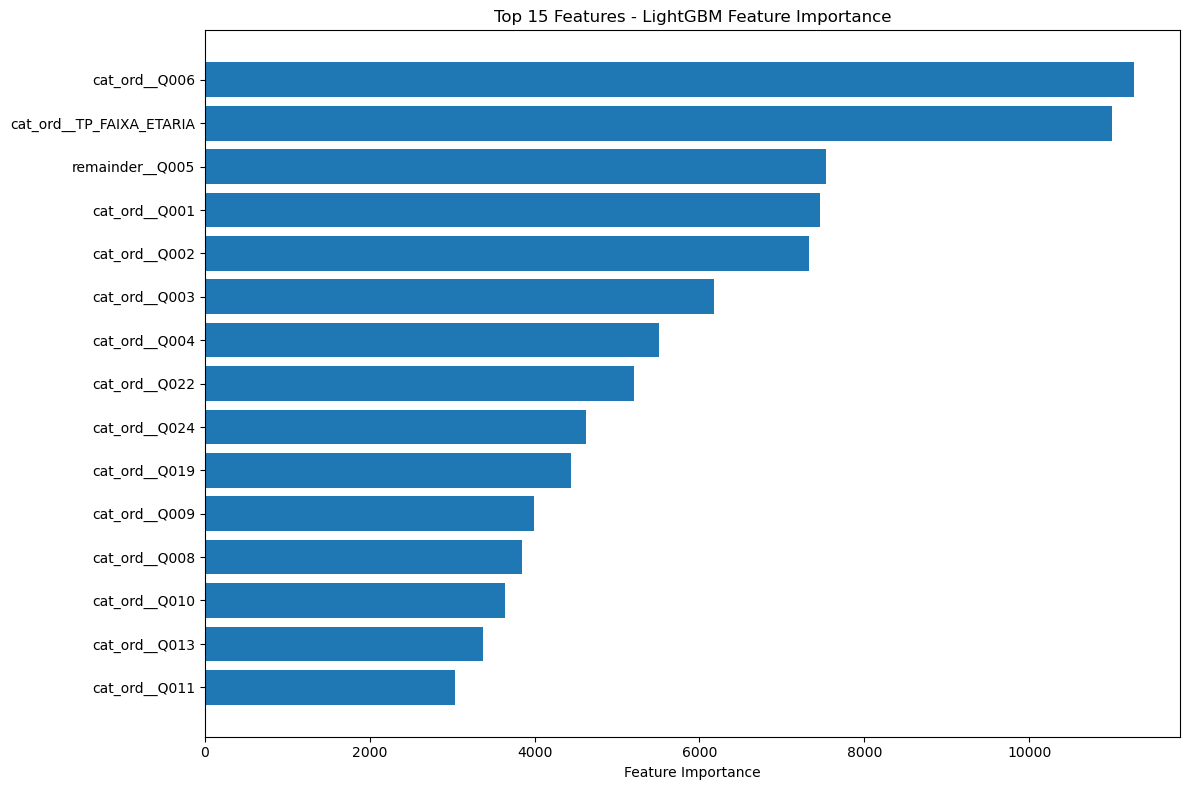


 SHAP Analysis:


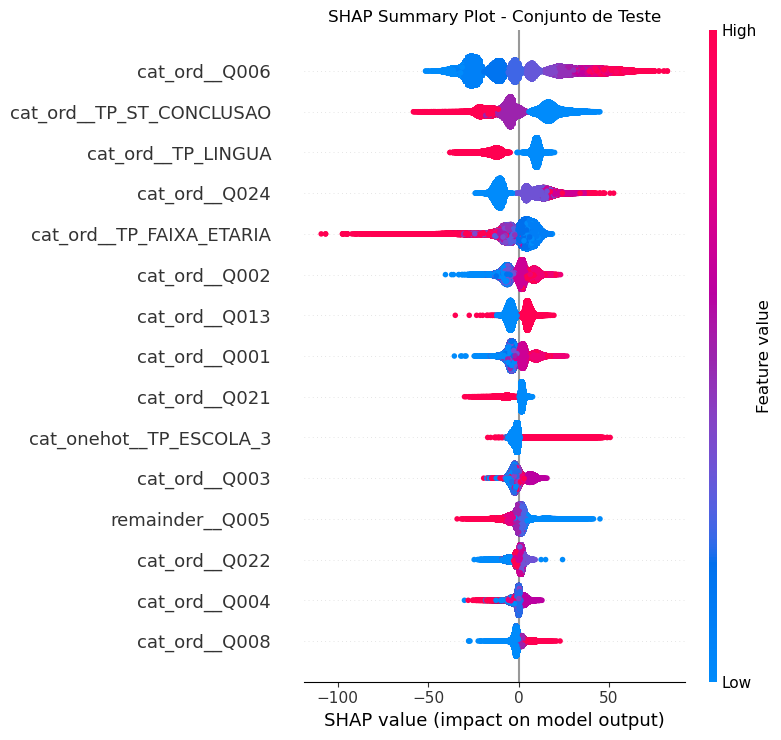

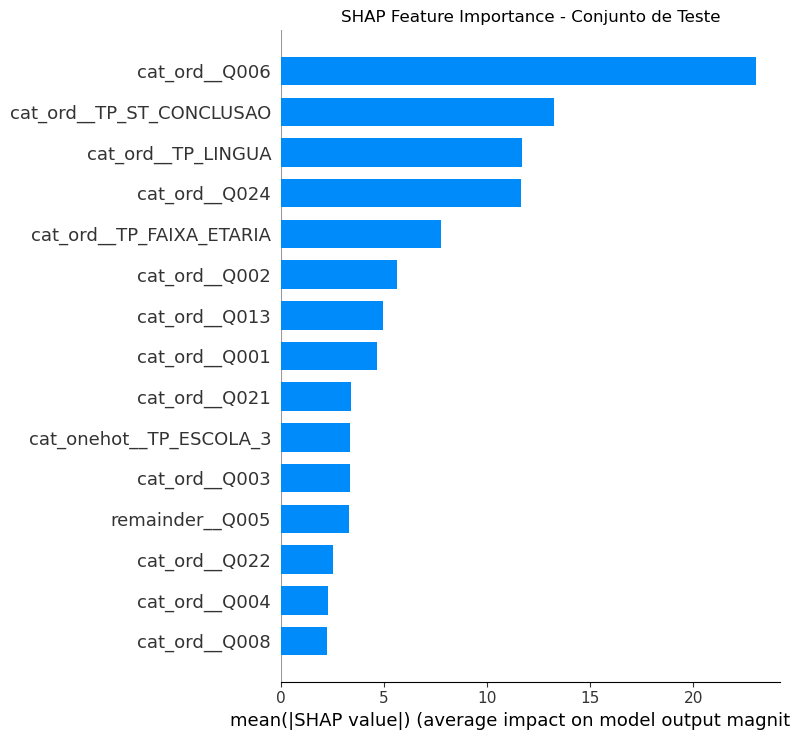

In [ ]:
# SHAP Feature Importance - usando dados de teste
import shap

# Processar todos os dados de teste para análise completa
X_test_processed = pipeline_final[:-1].transform(X_test)
modelo_final = pipeline_final.named_steps['modelo']

# Calcular SHAP para o conjunto de teste
explainer = shap.TreeExplainer(modelo_final)
shap_values = explainer.shap_values(X_test_processed)

print("\n ANÁLISE DE IMPORTÂNCIA DAS FEATURES:")

# Feature importance do modelo
feature_importance = modelo_final.feature_importances_

# Obter nomes reais das features após transformação
preprocessor = pipeline_final.named_steps['preprocess']
feature_names = preprocessor.get_feature_names_out()

# Plotar feature importance
plt.figure(figsize=(12, 8))
indices = np.argsort(feature_importance)[-15:]  # Top 15 features
plt.barh(range(len(indices)), feature_importance[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features - LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# SHAP plots
print("\n SHAP Analysis:")
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names, max_display=15, show=False)
plt.title('SHAP Summary Plot - Conjunto de Teste')
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, X_test_processed, plot_type="bar", feature_names=feature_names, max_display=15, show=False)
plt.title('SHAP Feature Importance - Conjunto de Teste')
plt.tight_layout()
plt.show()

# LightGBM Feature Importance - Análise
A análise de importância do LightGBM revelou que renda familiar (Q006) e faixa etária são as variáveis mais frequentemente utilizadas pelo algoritmo para criar divisões nas árvores de decisão, indicando sua importância estrutural no modelo. As variáveis de escolaridade dos pais (Q001, Q002) e remainder_Q005 ocupam posições intermediárias, confirmando que fatores socioeconômicos são os principais critérios algorítmicos para segmentação dos dados e predição das notas do ENEM.

# SHAP Summary Plot - Análise
Este gráfico mostra o impacto individual de cada variável nas predições do modelo, onde cada ponto representa um exemplo e as cores indicam valores altos (rosa) ou baixos (azul) da variável. A posição horizontal revela se a variável aumenta (direita) ou diminui (esquerda) a nota predita.

A renda familiar (Q006) apresenta o maior range de impacto (-100 a +50 pontos) com padrão claro: renda alta aumenta as notas, renda baixa diminui. A faixa etária mostra padrão inverso: candidatos mais jovens (azul) têm impacto positivo, enquanto mais velhos (rosa) têm impacto negativo, confirmando que jovens performam melhor no ENEM.
# SHAP Feature Importance - Análise
Este gráfico apresenta a importância média de cada variável calculada pela média dos valores SHAP absolutos, oferecendo uma visão simplificada de qual variável tem maior impacto médio nas predições do modelo. Diferente do Summary Plot, remove a complexidade das distribuições e cores, focando apenas na magnitude do impacto.

As duas variáveis mais importantes são cat_ord_Q006 (renda familiar) com aproximadamente 22 pontos de impacto médio, dominando significativamente todas as outras variáveis, e cat_ord_TP_ST_CONCLUSAO com cerca de 13 pontos, relacionada ao status de conclusão do ensino médio. Esta hierarquia confirma que fatores socioeconômicos fundamentais são os principais determinantes das predições do modelo.

 ## Conclusões Finais
 - A tunagem de hiperparâmetros com Optuna melhorou o RMSE de 75.83 para 75.12 no conjunto de teste.
 - A análise de importância das features revelou que variáveis como